In [2]:
!pip install librosa
!pip install noisereduce
!pip install scipy

In [1]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [ ]:
# Load the audio file
file_path = "R1023_20231115_060003.wav"  # Change this to your actual file path
y, sr = librosa.load(file_path, sr=None)

# Apply a Band-Pass Filter (Keep bird frequencies: ~1kHz to 8kHz)
lowcut = 1000  # 1 kHz
highcut = 8000  # 8 kHz

def bandpass_filter(data, sr, lowcut, highcut, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# Noise Reduction using noisereduce
reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.8)

# Save the cleaned bird sound
output_file = "bird_sounds_extracted.wav"
sf.write(output_file, reduced_noise, sr)

print(f"Processed audio saved as {output_file}")

In [5]:
print(sr)

32000


In [1]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

# Load the audio file
file_path = "R1023_20231115_060003.wav"  # Change this to your actual file path
y, sr = librosa.load(file_path, sr=None)

# Apply a Band-Pass Filter (Keep bird frequencies: ~1kHz to 8kHz)
lowcut = 1000  # 1 kHz
highcut = 4000  # 8 kHz

def bandpass_filter(data, sr, lowcut, highcut, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# Stronger Noise Reduction using noisereduce
reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.9)

# Spectral Subtraction for further noise removal
def spectral_subtraction(audio, noise_factor=0.05):
    stft = librosa.stft(audio)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_profile = np.mean(magnitude, axis=1, keepdims=True) * noise_factor
    enhanced_magnitude = np.maximum(magnitude - noise_profile, 0)
    return librosa.istft(enhanced_magnitude * np.exp(1j * phase))

cleaned_audio = spectral_subtraction(reduced_noise)

# Adaptive Gain Increase (Normalize & Amplify)
def adaptive_gain(audio, target_dB=-20):
    rms = np.sqrt(np.mean(audio ** 2))
    scalar = 10 ** ((target_dB - 20 * np.log10(rms)) / 20)
    return np.clip(audio * scalar, -1, 1)  # Prevent clipping

final_audio = adaptive_gain(cleaned_audio)

# Save the cleaned bird sound
output_file = "bird_sounds_extracted_enhanced_check.wav"
sf.write(output_file, final_audio, sr)

print(f"Processed audio saved as {output_file}")


: 

In [3]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

# Load the full 1-hour audio
file_path = "R1023_20231115_060003.wav"
y, sr = librosa.load(file_path, sr=None, duration=None)  # Ensure full duration is loaded

# Bandpass Filter (Preserves More Sound)
lowcut = 1000
highcut = 8000

def bandpass_filter(data, sr, lowcut, highcut, order=3):  # Lower order to preserve sound
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# Noise Reduction with Less Aggressive Reduction
reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.7)  # Less aggressive

# Spectral Subtraction (Avoid Over-Filtering)
def spectral_subtraction(audio, noise_factor=0.02):  # Reduce noise factor
    stft = librosa.stft(audio, n_fft=2048, hop_length=512)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_profile = np.mean(magnitude, axis=1, keepdims=True) * noise_factor
    enhanced_magnitude = np.maximum(magnitude - noise_profile, 0)
    return librosa.istft(enhanced_magnitude * np.exp(1j * phase), hop_length=512)  # Match hop_length

cleaned_audio = spectral_subtraction(reduced_noise)

# Adaptive Gain (Preserve Full Audio Length)
def adaptive_gain(audio, target_dB=-25):  # Reduce gain to avoid clipping
    rms = np.sqrt(np.mean(audio ** 2))
    scalar = 10 ** ((target_dB - 20 * np.log10(rms)) / 20)
    return np.clip(audio * scalar, -1, 1)

final_audio = adaptive_gain(cleaned_audio)

# Ensure the Output is the Same Length as Input
if len(final_audio) < len(y):
    padding = np.zeros(len(y) - len(final_audio))
    final_audio = np.concatenate((final_audio, padding))

# Save the fixed file
output_file = "bird_sounds_extracted_full.wav"
sf.write(output_file, final_audio, sr)

print(f"Processed full 1-hour audio saved as {output_file}")


Processed full 1-hour audio saved as bird_sounds_extracted_full.wav


In [5]:
import matplotlib.pyplot as plt

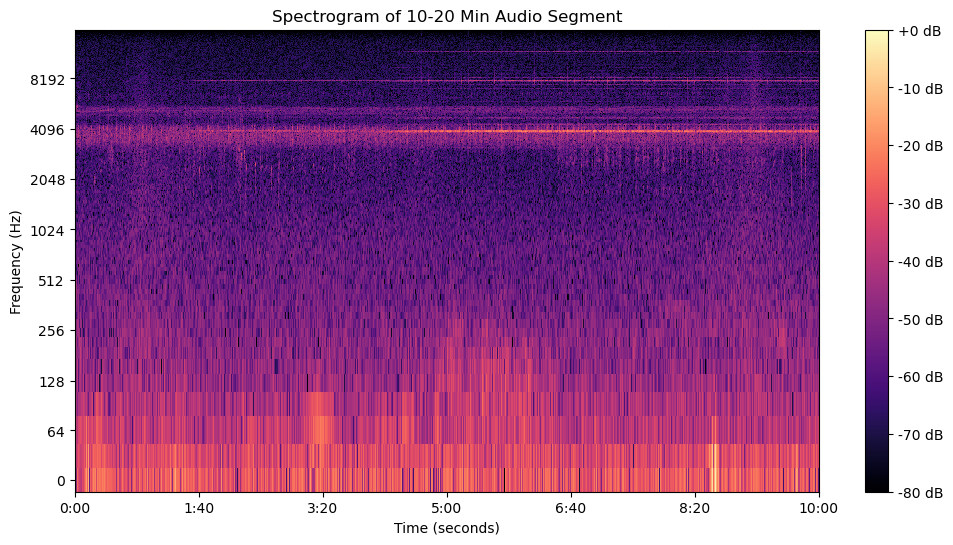

In [7]:
# Extract 10-20 min segment
start_time = 10 * 60  # 10 minutes in seconds
end_time = 20 * 60    # 20 minutes in seconds

start_sample = int(start_time * sr)
end_sample = int(end_time * sr)

segment_audio = y[start_sample:end_sample]

# Generate Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(segment_audio, n_fft=1024, hop_length=1024)), ref=np.max)

# Plot Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, sr=sr, hop_length=1024, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of 10-20 Min Audio Segment")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [6]:
import librosa
import librosa.display
import numpy as np
import noisereduce as nr
import scipy.signal as signal
import soundfile as sf

# Load the full 1-hour audio
file_path = "R1023_20231115_060003.wav"
y, sr = librosa.load(file_path, sr=None, duration=None)  # Load full duration

# Bandpass Filter (Preserves More Sound)
lowcut = 1000  # Hz
highcut = 8000  # Hz

def bandpass_filter(data, sr, lowcut, highcut, order=3):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

filtered_audio = bandpass_filter(y, sr, lowcut, highcut)

# **Detecting Ambient Noise Profile**
# Taking a small sample from the start (first 5 seconds) assuming it's mostly noise
noise_sample = filtered_audio[:sr * 10]

# **Noise Reduction with More Aggressive Reduction for Continuous Noise**
reduced_noise = nr.reduce_noise(y=filtered_audio, y_noise=noise_sample, sr=sr, prop_decrease=0.9)

## Notch Filter Design
def notch_filter(data, sr, freq, bw=100, order=2):  # bw is bandwidth, adjust as needed
    f0 = freq  # Frequency to be removed
    Q = f0 / bw  # Quality factor
    b, a = signal.iirnotch(f0 / (sr / 2), Q) # No order here
    return signal.filtfilt(b, a, data)


def spectral_subtraction(audio_chunk, sr, noise_sample):
    # 1. Notch Filter FIRST (remove the specific tone)
    notched_chunk = notch_filter(audio_chunk, sr, 8192)  # Remove 8192 Hz tone

    # 2. THEN Noise Reduction (for the remaining broadband noise)
    reduced_chunk = nr.reduce_noise(y=notched_chunk, y_noise=noise_sample, sr=sr, prop_decrease=0.9)

    # 3. Spectral Subtraction (for any residual noise)
    stft = librosa.stft(reduced_chunk, n_fft=2048, hop_length=512, dtype=np.float32)
    magnitude, phase = np.abs(stft), np.angle(stft)
    noise_profile = np.mean(magnitude, axis=1, keepdims=True) * 0.01
    enhanced_magnitude = np.maximum(magnitude - noise_profile, 0).astype(np.float32)
    cleaned_chunk = librosa.istft(enhanced_magnitude * np.exp(1j * phase), hop_length=512)

    return cleaned_chunk

def process_audio_in_chunks(audio, sr, chunk_duration=30, noise_duration=10):  # Added noise_duration
    cleaned_audio = []
    chunk_samples = int(chunk_duration * sr)
    noise_samples = int(noise_duration * sr) # Number of samples for initial noise profile

    # Initial Noise Profile (from the beginning of the audio)
    initial_noise_sample = audio[:noise_samples]

    for i in range(0, len(audio), chunk_samples):
        audio_chunk = audio[i:i + chunk_samples]

        # Update Noise Profile (You can make this more sophisticated later)
        if i == 0:
            noise_sample = initial_noise_sample
        #elif i % (chunk_samples * 2) == 0:  # Update noise every 2 chunks (example)
        #    noise_start = max(0, i - noise_samples) # Ensure we don't go before the beginning
        #    noise_sample = audio[noise_start:i] # Take the last noise_duration seconds before the current chunk
        else:
            noise_sample = initial_noise_sample # For now, keep using the initial noise sample

        cleaned_chunk = spectral_subtraction(audio_chunk, sr, noise_sample)
        cleaned_audio.extend(cleaned_chunk)

    return np.array(cleaned_audio)


cleaned_audio = process_audio_in_chunks(filtered_audio, sr)

# **Adaptive Gain (Preserve Full Audio Length)**
def adaptive_gain(audio, target_dB=-25):
    rms = np.sqrt(np.mean(audio ** 2))
    scalar = 10 ** ((target_dB - 20 * np.log10(rms)) / 20)
    return np.clip(audio * scalar, -1, 1)

final_audio = adaptive_gain(cleaned_audio)

# Ensure the Output is the Same Length as Input (important after chunking)
if len(final_audio) < len(y):
    padding = np.zeros(len(y) - len(final_audio))
    final_audio = np.concatenate((final_audio, padding))
elif len(final_audio) > len(y): # Handle the case where the output is longer
    final_audio = final_audio[:len(y)]  # Truncate to match input length

# Save the final cleaned audio
output_file = "bird_sounds_extracted_chunk_ambient_noise.wav"
sf.write(output_file, final_audio, sr)

print(f"Processed full 1-hour audio with ambient noise removed saved as {output_file}")


Processed full 1-hour audio with ambient noise removed saved as bird_sounds_extracted_chunk_ambient_noise.wav


In [8]:
import librosa
import numpy as np
import soundfile as sf
lowcut = 1000  # Hz
highcut = 8000  # Hz

def bandpass_filter(data, sr, lowcut, highcut, order=6):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, data)

def extract_frequency_range(audio_file, sr, lowcut=1100, highcut=4000):
    """
    Extracts a specific frequency range from an audio file.

    Args:
        audio_file (str): Path to the input audio file.
        sr (int): Sample rate of the audio. If None, it will be determined.
        lowcut (float): Lower cutoff frequency in Hz.
        highcut (float): Higher cutoff frequency in Hz.

    Returns:
        numpy.ndarray: The extracted audio data.
        int: The sample rate of the extracted audio (same as input)
        or None if there's an error.
    """
    try:
        y, sr = librosa.load(audio_file, sr=sr)  # Load the audio file
    except Exception as e:
        print(f"Error loading audio file: {e}")
        return None, None

    # 1. STFT
    filtered_audio = bandpass_filter(y, sr, lowcut, highcut)
    # Noise Reduction using noisereduce
    reduced_noise = nr.reduce_noise(y=filtered_audio, sr=sr, prop_decrease=0.8)
    stft = librosa.stft(reduced_noise, n_fft=2048, hop_length=512)  # Adjust n_fft and hop_length if needed
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=2048)  # Get the frequency bins
    print(np.abs(frequencies - lowcut))
    print(np.abs(frequencies - highcut))

    # 2. Find indices corresponding to the desired frequency range
    low_idx = np.argmin(np.abs(frequencies - lowcut))
    high_idx = np.argmin(np.abs(frequencies - highcut))

    # 3. Zero out the STFT outside the desired range
    stft_filtered = stft.copy()
    stft_filtered[:np.argmin(lowcut), :] = 0  # Zero out frequencies below lowcut
    stft_filtered[np.argmin(highcut) + 1:, :] = 0  # Zero out frequencies above highcut


    # 4. Inverse STFT
    y_filtered = librosa.istft(stft_filtered, hop_length=512)

    return y_filtered, sr


# Example usage:
audio_file = "R1023_20231115_060003.wav"  # Replace with your audio file path
sr = None # Let librosa detect the sample rate or set it manually.

filtered_audio, sr = extract_frequency_range(audio_file, sr)

if filtered_audio is not None and sr is not None:
    output_file = "filtered_audio5.wav"
    sf.write(output_file, filtered_audio, sr)  # Save the filtered audio
    print(f"Filtered audio saved to {output_file}")

[ 1100.     1084.375  1068.75  ... 14868.75  14884.375 14900.   ]
[ 4000.     3984.375  3968.75  ... 11968.75  11984.375 12000.   ]
Filtered audio saved to filtered_audio5.wav


In [10]:
import librosa
import soundfile as sf
import numpy as np
from scipy.signal import butter, lfilter

def apply_bandpass_filter(audio_file, output_file, lowcut, highcut, order=5):
    """Applies a bandpass filter (lowcut and highcut) to an audio file.

    Args:
        audio_file: Path to the input audio file.
        output_file: Path to save the filtered audio.
        lowcut: Lower cutoff frequency (Hz).
        highcut: Higher cutoff frequency (Hz).
        order: Order of the Butterworth filter (higher order = steeper cutoff).
    """

    # 1. Load audio
    y, sr = librosa.load(audio_file, sr=None)  # Load with original sample rate

    # 2. Design the Butterworth filter
    nyquist = 0.5 * sr  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandpass')  # Bandpass filter

    # 3. Apply the filter
    y_filtered = lfilter(b, a, y)

    # 4. Normalize (optional but recommended)
    y_filtered = y_filtered / np.max(np.abs(y_filtered)) # prevents clipping

# 5. Save the filtered audio
    sf.write(output_file, y_filtered, sr)

# Example Usage:
input_audio = "R1023_20231115_060003.wav"
output_audio = "filtered_audio2.wav"

lowcut_freq = 500  # Example: 500 Hz lowcut
highcut_freq = 4000 # Example: 5000 Hz highcut

apply_bandpass_filter(input_audio, output_audio, lowcut_freq, highcut_freq)
print(f"Filtered audio saved to {output_audio}")


# --- For Highpass only (removing low frequencies) ---
# def apply_highpass_filter(audio_file, output_file, cutoff, order=5):
#     nyquist = 0.5 * sr
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
#     y_filtered = lfilter(b, a, y)
#     y_filtered = y_filtered / np.max(np.abs(y_filtered))
#     sf.write(output_file, y_filtered, sr)

# # Example Highpass:
# # apply_highpass_filter(input_audio, "highpass_audio.wav", 1000) # Cutoff at 1kHz


# # --- For Lowpass only (removing high frequencies) ---
# def apply_lowpass_filter(audio_file, output_file, cutoff, order=5):
#     nyquist = 0.5 * sr
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
#     y_filtered = lfilter(b, a, y)
#     y_filtered = y_filtered / np.max(np.abs(y_filtered))
#     sf.write(output_file, y_filtered, sr)

# Example Lowpass:
# apply_lowpass_filter(input_audio, "lowpass_audio.wav", 2000) # Cutoff at 2kHz

Filtered audio saved to filtered_audio2.wav


In [ ]:
import librosa
import noisereduce as nr
y, sr = librosa.load("R1023_20231115_060003.wav", sr=None)

# Reduce noise (assuming first 1 sec is noise)
reduced_noise = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.9)

# Save the cleaned audio
librosa.output.write_wav("denoised_forest.wav", reduced_noise, sr)

In [3]:
!pip uninstall deepfilternet

DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\jiter-0.8.2-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\langchain_text_splitters-0.3.5-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\langsmith-0.3.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\mcqgenerator-0.0.1-py3.12.egg is depre

In [5]:
!pip install demucs

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
      --------------------------------------- 0.0/1.2 MB 162.5 kB/s eta 0:00:08
     - -------------------------------------- 0.0/1.2 MB 163.8 kB/s eta 0:00:08
     -- ------------------------------------- 0.1/1.2 MB 252.2 kB/s eta 0:00:05
     ---- ----------------------------------- 0.1/1.2 MB 423.5 kB/s eta 0:00:03
     --------------- ------------------------ 0.5/1.2 MB 1.5 MB/s eta 0:00:01
     ---------------------- ----------------- 0.7/1.2 MB 1.9 MB/s eta 0:00:01
     ---------------------------------------  1.2/1.2 MB 3.0 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/87.

DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\jiter-0.8.2-py3.12-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\langchain_text_splitters-0.3.5-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\langsmith-0.3.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\aazhm\anaconda3\lib\site-packages\mcqgenerator-0.0.1-py3.12.egg is depre

In [13]:
from demucs import pretrained
from demucs.apply import apply_model
import torch
import torchaudio

# Load audio file
waveform, sr = torchaudio.load("R1023_20231115_060003.wav")

# Convert mono (1-channel) to stereo (2-channel)
if waveform.shape[0] == 1:  
    waveform = waveform.repeat(2, 1)  # Duplicate channel: (2, samples)

# Load pre-trained Demucs model
model = pretrained.get_model("htdemucs")

# Add batch dimension
waveform = waveform.unsqueeze(0)  # Shape: (1, 2, samples)

# Apply model for denoising
with torch.no_grad():
    sources = apply_model(model, waveform, device="cuda")  # Use "cuda" if GPU is available

# Extract the main source (e.g., speech or foreground sounds)
denoised_audio = sources[0, 0]  # First source, first channel

# Save the denoised audio
torchaudio.save("denoised_forest1.wav", denoised_audio, sr)


In [1]:
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

# Load audio file
waveform, sr = torchaudio.load("bird-10.wav")

# Convert to NumPy
waveform = waveform.numpy()

# If stereo, use only one channel
if waveform.shape[0] > 1:
    waveform = waveform[0]  # Take only the first channel

# Select a smaller segment (e.g., first 1 second)
duration = 1  # seconds
samples = sr * duration  # Number of samples in 1 second
waveform = waveform[:samples]

# Compute FFT
N = len(waveform)
frequencies = np.fft.fftfreq(N, d=1/sr)  # Frequency axis
spectrum = np.fft.fft(waveform)  # Compute FFT
magnitude = np.abs(spectrum)  # Get magnitude

# Plot Spectrum
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:N//2], magnitude[:N//2])  # Only show positive frequencies
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("DFT Spectrum of Audio File (1s Segment)")
plt.grid()
plt.show()


KeyboardInterrupt: 

: 

In [2]:
import librosa
import noisereduce as nr
import soundfile as sf  # ✅ Import soundfile for saving audio

# Load audio
y, sr = librosa.load("R1023_20231115_060003.wav", sr=None)

# Reduce noise (assuming first 1 sec is noise)
reduced_noise = nr.reduce_noise(y=y, sr=sr, prop_decrease=0.9)

# Save the cleaned audio using soundfile
sf.write("denoised_forest2.wav", reduced_noise, sr)


In [3]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

# Compute Short-Time Energy
frame_length = 2048
hop_length = 512
energy = librosa.feature.rms(y=reduced_noise, frame_length=frame_length, hop_length=hop_length)[0]

# Identify segments above a threshold
threshold = np.percentile(energy, 75)  # Adjust based on the data
speech_indices = np.where(energy > threshold)[0]

# Extract segments
segment_times = librosa.frames_to_time(speech_indices, sr=sr, hop_length=hop_length)


In [7]:
from sklearn.preprocessing import StandardScaler

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=reduced_noise, sr=sr, n_mfcc=13)


# Normalize features
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs.T)


In [5]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(mfccs_scaled)


In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import IPython.display as ipd


pca = PCA(n_components=2)
pca_features = pca.fit_transform(mfccs_scaled)

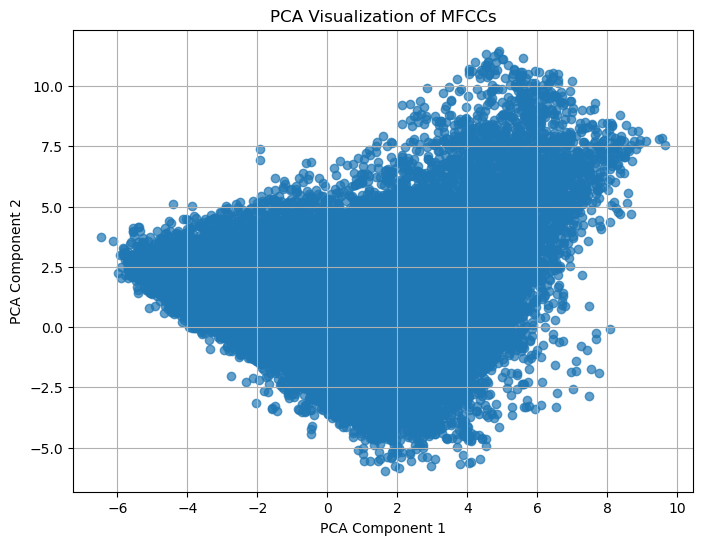

In [9]:
# Plot PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of MFCCs")
plt.grid()
plt.show()

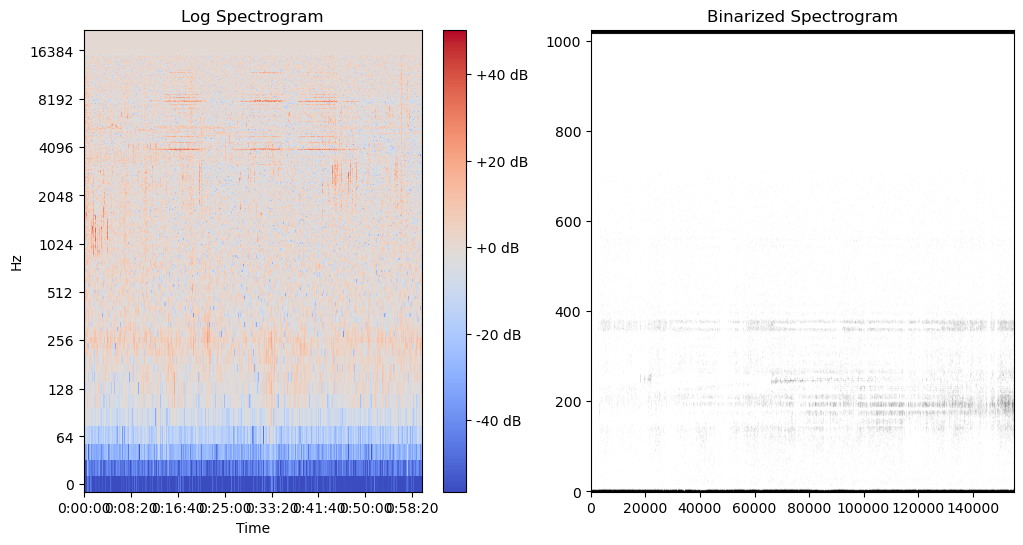

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing

def bandpass_filter(y, sr, lowcut=100, highcut=18000, order=5):
    sos = scipy.signal.butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, y)

def compute_spectrogram(y, sr, n_fft=2048, hop_length=1024):
    window = scipy.signal.windows.hann(n_fft)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))
    return librosa.amplitude_to_db(S, ref=np.max)

def remove_noise(spectrogram):
    noise_profile = np.mean(spectrogram, axis=1)  # Estimate noise profile
    smoothed_noise = np.convolve(noise_profile, np.ones(25)/25, mode='same')
    return spectrogram - smoothed_noise[:, np.newaxis]

def binarize_spectrogram(spectrogram):
    threshold = threshold_otsu(spectrogram)
    binary_spectrogram = spectrogram > threshold
    return binary_closing(binary_spectrogram)

def process_audio(file_path):
    y, sr = librosa.load(file_path, sr=44100, mono=True)  # Load as mono
    y_filtered = bandpass_filter(y, sr)
    spectrogram = compute_spectrogram(y_filtered, sr)
    spectrogram = remove_noise(spectrogram)
    binary_spectrogram = binarize_spectrogram(spectrogram)
    return spectrogram, binary_spectrogram, sr

def visualize_spectrograms(file_path):
    spectrogram, binary_spectrogram, sr = process_audio(file_path)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=1024, x_axis='time', y_axis='log')
    plt.title("Log Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    
    plt.subplot(1, 2, 2)
    plt.imshow(binary_spectrogram, aspect='auto', cmap='gray', origin='lower')
    plt.title("Binarized Spectrogram")
    
    plt.show()

# Example usage
visualize_spectrograms("R1023_20231115_060003.wav")

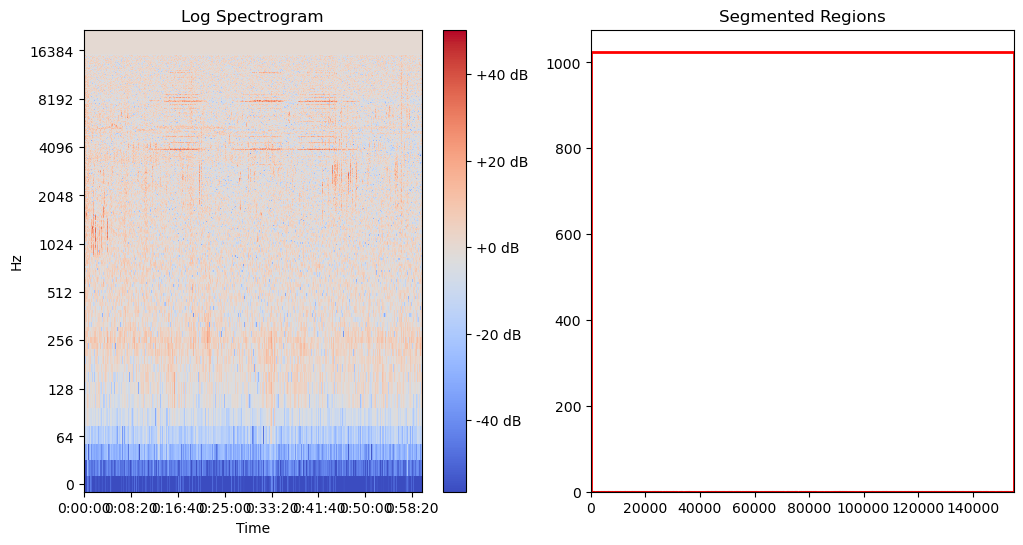

In [4]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing
from scipy.ndimage import label, find_objects

# Band-pass filter
def bandpass_filter(y, sr, lowcut=100, highcut=18000, order=5):
    sos = scipy.signal.butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, y)

# Compute log spectrogram
def compute_spectrogram(y, sr, n_fft=2048, hop_length=1024):
    window = scipy.signal.windows.hann(n_fft)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))
    return librosa.amplitude_to_db(S, ref=np.max)

# Noise removal
def remove_noise(spectrogram):
    noise_profile = np.mean(spectrogram, axis=1)
    smoothed_noise = np.convolve(noise_profile, np.ones(25) / 25, mode='same')
    return spectrogram - smoothed_noise[:, np.newaxis]

# Hysteresis thresholding for binarization
def binarize_spectrogram(spectrogram, high_threshold=-20, low_threshold=-40):
    binary_high = spectrogram > high_threshold  # Strong signal
    binary_low = spectrogram > low_threshold    # Weak signal

    # Region growing: Keep weak signals connected to strong ones
    labeled, num_features = label(binary_low)
    binary_spectrogram = np.zeros_like(binary_low, dtype=bool)

    for i in range(1, num_features + 1):
        region = (labeled == i)
        if np.any(region & binary_high):  # Keep only connected regions
            binary_spectrogram |= region

    return binary_closing(binary_spectrogram)  # Remove small holes

# Find bounding boxes and merge them
def find_and_merge_bounding_boxes(binary_spectrogram, sr, hop_length=1024, time_threshold=0.24, freq_threshold=170, min_duration=0.36):
    labeled, num_features = label(binary_spectrogram)
    bboxes = []

    for region in find_objects(labeled):
        if region is not None:
            time_start, time_end = region[1].start, region[1].stop
            freq_start, freq_end = region[0].start, region[0].stop

            duration = (time_end - time_start) * hop_length / sr  # Convert to seconds
            freq_range = freq_end - freq_start  # In Hz (assuming linear scale)

            if duration >= min_duration:
                bboxes.append((time_start, time_end, freq_start, freq_end, duration, freq_range))

    # Merge bounding boxes that are close in time & frequency
    merged_bboxes = []
    for bbox in bboxes:
        merged = False
        for i, m_bbox in enumerate(merged_bboxes):
            time_diff = (bbox[0] - m_bbox[1]) * hop_length / sr
            freq_diff = abs(bbox[2] - m_bbox[3])

            if time_diff < time_threshold and freq_diff < freq_threshold:
                # Merge the bounding boxes
                merged_bboxes[i] = (min(bbox[0], m_bbox[0]), max(bbox[1], m_bbox[1]),
                                    min(bbox[2], m_bbox[2]), max(bbox[3], m_bbox[3]),
                                    max(bbox[4], m_bbox[4]), max(bbox[5], m_bbox[5]))
                merged = True
                break

        if not merged:
            merged_bboxes.append(bbox)

    return merged_bboxes

# Process audio and extract segmentation
def process_audio(file_path):
    y, sr = librosa.load(file_path, sr=44100, mono=True)
    y_filtered = bandpass_filter(y, sr)
    spectrogram = compute_spectrogram(y_filtered, sr)
    spectrogram = remove_noise(spectrogram)
    binary_spectrogram = binarize_spectrogram(spectrogram)

    # Find and merge bounding boxes
    bounding_boxes = find_and_merge_bounding_boxes(binary_spectrogram, sr)

    return spectrogram, binary_spectrogram, bounding_boxes, sr

# Visualize results
def visualize_results(file_path):
    spectrogram, binary_spectrogram, bounding_boxes, sr = process_audio(file_path)

    plt.figure(figsize=(12, 6))

    # Spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=1024, x_axis='time', y_axis='log')
    plt.title("Log Spectrogram")
    plt.colorbar(format='%+2.0f dB')

    # Bounding boxes on binarized spectrogram
    plt.subplot(1, 2, 2)
    plt.imshow(binary_spectrogram, aspect='auto', cmap='gray', origin='lower')
    plt.title("Segmented Regions")
    
    # Draw bounding boxes
    hop_length = 1024
    for bbox in bounding_boxes:
        time_start, time_end, freq_start, freq_end, _, _ = bbox
        plt.plot([time_start, time_start, time_end, time_end, time_start],
                 [freq_start, freq_end, freq_end, freq_start, freq_start],
                 color='red', linewidth=2)

    plt.show()

# Example usage
visualize_results("R1023_20231115_060003.wav")


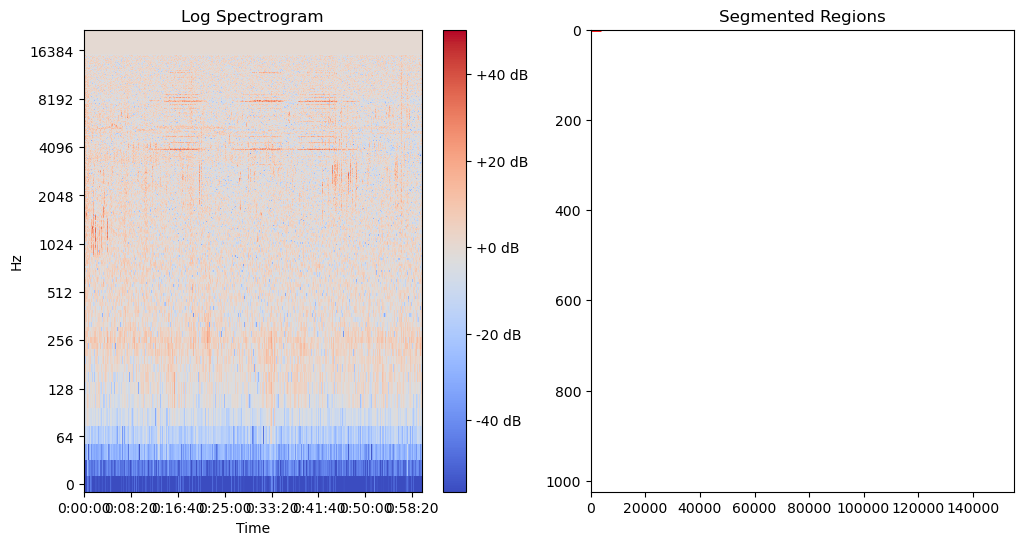

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing
from scipy.ndimage import label, find_objects

# Band-pass filter
def bandpass_filter(y, sr, lowcut=100, highcut=18000, order=5):
    sos = scipy.signal.butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return scipy.signal.sosfilt(sos, y)

# Compute log spectrogram
def compute_spectrogram(y, sr, n_fft=2048, hop_length=1024):
    window = scipy.signal.windows.hann(n_fft)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))
    return librosa.amplitude_to_db(S, ref=np.max)

# Noise removal
def remove_noise(spectrogram):
    noise_profile = np.mean(spectrogram, axis=1)
    smoothed_noise = np.convolve(noise_profile, np.ones(25) / 25, mode='same')
    return spectrogram - smoothed_noise[:, np.newaxis]

# Hysteresis thresholding for binarization
def binarize_spectrogram(spectrogram, high_threshold=-20, low_threshold=-50):
    binary_high = spectrogram > high_threshold  # Strong signal
    binary_low = spectrogram > low_threshold    # Weak signal

    # Region growing: Keep weak signals connected to strong ones
    labeled, num_features = label(binary_low)
    binary_spectrogram = np.zeros_like(binary_low, dtype=bool)

    for i in range(1, num_features + 1):
        region = (labeled == i)
        if np.any(region & binary_high):  # Keep only connected regions
            binary_spectrogram |= region

    return binary_closing(binary_spectrogram)  # Remove small holes

# Find bounding boxes and merge them
def find_and_merge_bounding_boxes(binary_spectrogram, sr, hop_length=1024, time_threshold=0.24, freq_threshold=170, min_duration=0.36):
    labeled, num_features = label(binary_spectrogram)
    bboxes = []

    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)  # Convert frequency bins to Hz

    for region in find_objects(labeled):
        if region is not None:
            time_start, time_end = region[1].start, region[1].stop
            freq_start, freq_end = region[0].start, region[0].stop

            time_start_sec = time_start * hop_length / sr
            time_end_sec = time_end * hop_length / sr
            freq_start_hz = freqs[freq_start] if freq_start < len(freqs) else 0
            freq_end_hz = freqs[freq_end] if freq_end < len(freqs) else 0

            duration = time_end_sec - time_start_sec  # In seconds
            freq_range = freq_end_hz - freq_start_hz  # In Hz

            if duration >= min_duration:
                bboxes.append((time_start_sec, time_end_sec, freq_start_hz, freq_end_hz, duration, freq_range))

    # Merge bounding boxes that are close in time & frequency
    merged_bboxes = []
    for bbox in bboxes:
        merged = False
        for i, m_bbox in enumerate(merged_bboxes):
            time_diff = bbox[0] - m_bbox[1]
            freq_diff = abs(bbox[2] - m_bbox[3])

            if time_diff < time_threshold and freq_diff < freq_threshold:
                # Merge the bounding boxes
                merged_bboxes[i] = (min(bbox[0], m_bbox[0]), max(bbox[1], m_bbox[1]),
                                    min(bbox[2], m_bbox[2]), max(bbox[3], m_bbox[3]),
                                    max(bbox[4], m_bbox[4]), max(bbox[5], m_bbox[5]))
                merged = True
                break

        if not merged:
            merged_bboxes.append(bbox)

    return merged_bboxes

# Process audio and extract segmentation
def process_audio(file_path):
    y, sr = librosa.load(file_path, sr=44100, mono=True)
    y_filtered = bandpass_filter(y, sr)
    spectrogram = compute_spectrogram(y_filtered, sr)
    spectrogram = remove_noise(spectrogram)
    binary_spectrogram = binarize_spectrogram(spectrogram)

    # Find and merge bounding boxes
    bounding_boxes = find_and_merge_bounding_boxes(binary_spectrogram, sr)

    return spectrogram, binary_spectrogram, bounding_boxes, sr

# Visualize results
def visualize_results(file_path):
    spectrogram, binary_spectrogram, bounding_boxes, sr = process_audio(file_path)

    plt.figure(figsize=(12, 6))

    # Spectrogram
    plt.subplot(1, 2, 1)
    librosa.display.specshow(spectrogram, sr=sr, hop_length=1024, x_axis='time', y_axis='log')
    plt.title("Log Spectrogram")
    plt.colorbar(format='%+2.0f dB')

    # Bounding boxes on binarized spectrogram
    plt.subplot(1, 2, 2)
    plt.imshow(binary_spectrogram, aspect='auto', cmap='gray', origin='lower')
    plt.title("Segmented Regions")

    # Draw bounding boxes with correct scaling
    ax = plt.gca()
    for bbox in bounding_boxes:
        time_start, time_end, freq_start, freq_end, _, _ = bbox
        rect = plt.Rectangle((time_start, freq_start), time_end - time_start, freq_end - freq_start, 
                             linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.gca().invert_yaxis()  # Ensure frequency is plotted correctly
    plt.show()

# Example usage
visualize_results("R1023_20231115_060003.wav")


In [7]:
import librosa
import librosa.display
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.signal import butter, sosfilt
from IPython.display import Audio

def bandpass_filter(y, sr, lowcut=100, highcut=18000, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfilt(sos, y)

def compute_spectrogram(y, sr, n_fft=2048, hop_length=1024):
    window = scipy.signal.windows.hann(n_fft)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))
    return librosa.amplitude_to_db(S, ref=np.max)

def remove_noise(spectrogram):
    noise_profile = np.mean(spectrogram, axis=1)  # Estimate noise profile
    smoothed_noise = np.convolve(noise_profile, np.ones(25)/25, mode='same')
    return spectrogram - smoothed_noise[:, np.newaxis]

def binarize_spectrogram(spectrogram):
    threshold = threshold_otsu(spectrogram)
    return spectrogram > threshold

def process_audio(file_path):
    y, sr = librosa.load(file_path, sr=44100, mono=True)
    y_filtered = bandpass_filter(y, sr)
    spectrogram = compute_spectrogram(y_filtered, sr)
    spectrogram = remove_noise(spectrogram)
    binary_spectrogram = binarize_spectrogram(spectrogram)
    return spectrogram, binary_spectrogram, sr

def reconstruct_audio_from_spectrogram(spectrogram, sr, n_fft=2048, hop_length=1024):
    """ Convert spectrogram back to time-domain audio using Griffin-Lim algorithm """
    S = librosa.db_to_amplitude(spectrogram)
    y_reconstructed = librosa.griffinlim(S, n_iter=32, hop_length=hop_length, win_length=n_fft)
    return y_reconstructed

# Load, process, and reconstruct
file_path = "R1023_20231115_060003.wav"
spectrogram, binary_spectrogram, sr = process_audio(file_path)
y_reconstructed = reconstruct_audio_from_spectrogram(spectrogram, sr)

# Play the preprocessed audio
Audio(y_reconstructed, rate=sr)


KeyboardInterrupt: 

In [8]:
import librosa
import librosa.display
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.signal import butter, sosfilt
from IPython.display import Audio


In [9]:
y, sr = librosa.load(file_path, sr=44100, mono=True)
n_fft = 2048
hop_length = 1024
sos = butter(5, [100, 18000], btype='band', fs=sr, output='sos')
y_filtered = sosfilt(sos, y)
window = scipy.signal.windows.hann(n_fft)
S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window))
spectrogram = librosa.amplitude_to_db(S, ref=np.max)
noise_profile = np.mean(spectrogram, axis=1)  # Estimate noise profile
smoothed_noise = np.convolve(noise_profile, np.ones(25)/25, mode='same')
spectrogram - smoothed_noise[:, np.newaxis]
spectrogram

array([[-52.395824, -43.371616, -31.554272, ..., -27.630861, -35.735497,
        -39.813316],
       [-44.73365 , -41.698776, -37.03887 , ..., -33.03907 , -43.177948,
        -46.34983 ],
       [-41.70123 , -49.981285, -43.60564 , ..., -39.065872, -40.993813,
        -46.436485],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [ ]:
import librosa
import numpy as np
import scipy.signal
from scipy.signal import sosfilt, butter
import soundfile as sf

# Load the audio file
y, sr = librosa.load(file_path, sr=44100, mono=True)

# Filter design
n_fft = 2048
hop_length = 1024
sos = butter(5, [100, 18000], btype='band', fs=sr, output='sos')
y_filtered = sosfilt(sos, y)

# Window for STFT
window = scipy.signal.windows.hann(n_fft)

# Compute the STFT
S = np.abs(librosa.stft(y_filtered, n_fft=n_fft, hop_length=hop_length, window=window))

# Convert to decibels (spectrogram)
spectrogram = librosa.amplitude_to_db(S, ref=np.max)

# Estimate noise profile (mean across time)
noise_profile = np.mean(spectrogram, axis=1)

# Smooth the noise profile to reduce fluctuations
smoothed_noise = np.convolve(noise_profile, np.ones(25)/25, mode='same')

# Reconstruct the noise signal using the smoothed noise profile
# Inverse STFT is not directly applicable to the noise profile, so we need to synthesize noise in the time domain

# Create synthetic noise signal with the same length as the original audio
noise_time_domain = np.zeros_like(y)

# Apply a filter to make it match the noise profile's frequency characteristics
# Use a simple white noise generator and shape it based on the noise profile

# Generate white noise
white_noise = np.random.randn(len(y))

# Apply a filter to match the frequency characteristics of the noise profile
filtered_noise = sosfilt(sos, white_noise)

# If you want to save the preprocessed noise to a file
sf.write('preprocessed_noise.wav', filtered_noise, sr)

# Alternatively, if you want to listen to the noise directly in the notebook, use librosa.display or an audio playback library
import IPython.display as ipd
ipd.Audio(filtered_noise, rate=sr)


In [ ]:
import librosa
import librosa.display
import numpy as np
import scipy.signal
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def load_audio(file_path, sr=22050):
    """Load an audio file and convert it to mono."""
    y, sr = librosa.load(file_path, sr=sr, mono=True)
    return y, sr

def compute_spectrogram(y, n_fft=2048, hop_length=512):
    """Compute magnitude spectrogram using STFT."""
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    return S

def extract_mfcc(y, sr, n_mfcc=13):
    """Extract MFCC features from the audio signal."""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def reduce_noise(y, sr, noise_factor=0.02):
    """Apply simple noise reduction by subtracting estimated noise."""
    noise = np.random.randn(len(y)) * noise_factor
    y_denoised = y - noise
    return y_denoised

def augment_audio(y, sr):
    """Perform data augmentation (time-stretching and pitch shifting)."""
    y_stretched = librosa.effects.time_stretch(y, rate=0.8)
    y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
    return y_stretched, y_shifted

def segment_audio(y, sr, segment_length=2.0):
    """Segment audio into smaller chunks for better feature extraction."""
    segment_samples = int(segment_length * sr)
    segments = [y[i:i+segment_samples] for i in range(0, len(y), segment_samples)]
    return segments


def cluster_segments(features, n_clusters=5):
    """Apply k-means clustering to segment the bird songs."""
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)

    return labels

# ---- Pipeline Execution ----
file_path = "R1023_20231115_060003.wav"  # Replace with actual file path
y, sr = load_audio(file_path)

# Preprocessing
y_denoised = reduce_noise(y, sr)
y_stretched, y_shifted = augment_audio(y, sr)

# Save preprocessed versions
sf.write("denoised_audio.wav", y_denoised, sr)
sf.write("stretched_audio.wav", y_stretched, sr)
sf.write("shifted_audio.wav", y_shifted, sr)

# Segmentation
segments = segment_audio(y_denoised, sr)

# Feature Extraction


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 13 and the array at index 1 has size 1

In [2]:
print(segments)

[array([ 0.00485125,  0.06723479,  0.00197143, ..., -0.01571835,
        0.03923706, -0.02174865]), array([-0.04685468,  0.04075319,  0.08883954, ..., -0.07356563,
        0.03135324,  0.03868065]), array([ 0.00287556, -0.02029139, -0.03759187, ...,  0.00242497,
        0.00349843,  0.03445528]), array([-0.00732303,  0.05732748, -0.0091849 , ..., -0.0275064 ,
        0.02117428,  0.06141258]), array([ 0.01870089,  0.00246257, -0.00360332, ...,  0.04138288,
        0.02234737, -0.01035356]), array([-0.00770946, -0.01262667, -0.0255892 , ..., -0.00622862,
        0.00757135, -0.00603585]), array([-0.00711777,  0.01535418, -0.00261459, ...,  0.00309955,
        0.00644607, -0.0359289 ]), array([ 0.03442179, -0.02570992,  0.00702133, ..., -0.00101822,
        0.02272809,  0.03146244]), array([ 3.81629118e-02, -1.47383237e-02, -5.87110477e-03, ...,
        7.74286550e-05, -1.07966393e-02, -3.96626022e-03]), array([-1.66654949e-03, -1.67072112e-03, -4.70563458e-03, ...,
       -4.64906741e-0

In [3]:
def extract_features(segments, sr):
    """Extract MFCCs, spectral centroid, and zero-crossing rate from each segment."""
    feature_list = []
    
    for seg in segments:
        if len(seg) < sr * 0.5:  # Ignore segments too short
            continue

        mfccs = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=seg, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(seg)

        # Flatten single-value features to match MFCC shape
        spectral_centroid = np.tile(spectral_centroid, (13, 1))  # Repeat to match MFCC shape
        zero_crossing_rate = np.tile(zero_crossing_rate, (13, 1))

        # Stack features together
        features = np.vstack((np.mean(mfccs, axis=1), 
                              np.mean(spectral_centroid, axis=1),
                              np.mean(zero_crossing_rate, axis=1)))

        feature_list.append(features.T)

    return np.vstack(feature_list)  # Combine all extracted features


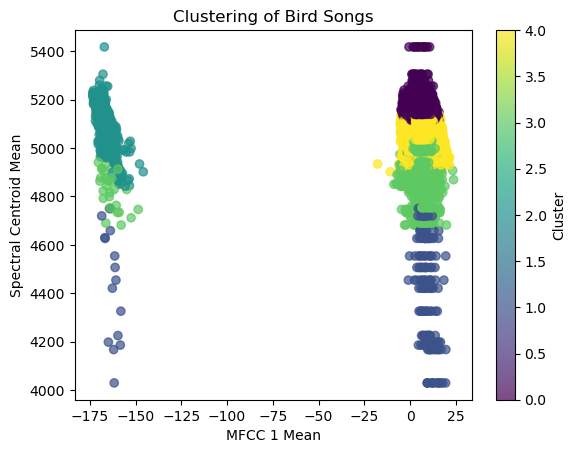

Audio processing and clustering completed.


In [4]:
features = extract_features(segments, sr)

# Unsupervised Classification (Clustering)
labels = cluster_segments(features, n_clusters=5)

# Visualizing Clusters
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.xlabel("MFCC 1 Mean")
plt.ylabel("Spectral Centroid Mean")
plt.title("Clustering of Bird Songs")
plt.colorbar(label="Cluster")
plt.show()

print("Audio processing and clustering completed.")


In [5]:
from sklearn.metrics import silhouette_score

def evaluate_clusters(features, labels):
    score = silhouette_score(features, labels)
    print(f"Silhouette Score: {score:.3f}")

evaluate_clusters(features, labels)


Silhouette Score: 0.536


In [6]:
species_map = {
    0: "Sparrow",
    1: "Robin",
    2: "Crow",
    3: "Blue Jay",
    4: "Woodpecker"
}

labeled_clusters = [species_map[label] for label in labels]
print(labeled_clusters[:10])  # Check first 10 labeled samples


['Crow', 'Woodpecker', 'Woodpecker', 'Woodpecker', 'Woodpecker', 'Woodpecker', 'Woodpecker', 'Woodpecker', 'Woodpecker', 'Woodpecker']


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
clf = SVC(kernel="linear")
clf.fit(X_train, y_train)

print(f"Classifier Accuracy: {clf.score(X_test, y_test) * 100:.2f}%")


Classifier Accuracy: 92.80%
